In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm, t, johnsonsu
import requests
from io import BytesIO, StringIO
from zipfile import ZipFile
import properscoring as ps
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Download data from Ken French's website
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
response = requests.get(url)

with ZipFile(BytesIO(response.content)) as zfile:
    with zfile.open('F-F_Research_Data_Factors.CSV') as file:
        csv_data = pd.read_csv(file, skiprows=3, index_col=0)

# Convert the data to numeric format and drop rows with missing values
csv_data = csv_data.apply(pd.to_numeric, errors='coerce').dropna()

# Keep only the monthly observations
csv_data = csv_data[csv_data.index.map(lambda x: x.isdigit() and len(x) == 6)]

# Step 2: Compute Mkt and m
csv_data['Mkt'] = csv_data['Mkt-RF'] + csv_data['RF']
csv_data['m'] = (csv_data['Mkt-RF'] / 100) / (1 + csv_data['RF'] / 100)

# Step 3: Split data into folds
fold1 = csv_data.loc['192607':'198312']
fold2 = csv_data.loc['198301':'201212']
fold3 = csv_data.loc['201301':'201812']
fold4 = csv_data.loc['201901':]

# Step 4: Fit models to fold1
m1 = fold1['m']
params_normal = norm.fit(m1)
params_t = t.fit(m1)
params_johnsonsu = johnsonsu.fit(m1)

# Step 5: Select among the three models using CRPS on fold2
m2 = fold2['m']

crps_normal = np.mean(ps.crps_ensemble(m2, norm.rvs(*params_normal, size=len(m2))))
crps_t = np.mean(ps.crps_ensemble(m2, t.rvs(*params_t, size=len(m2))))
crps_johnsonsu = np.mean(ps.crps_ensemble(m2, johnsonsu.rvs(*params_johnsonsu, size=len(m2))))

# Step 6: Report the best model and the fitted parameters
best_model = min([(crps_normal, 'Normal', params_normal),
                  (crps_t, 'Student t', params_t),
                  (crps_johnsonsu, 'Johnson Su', params_johnsonsu)], key=lambda x: x[0])

print(f"Best model: {best_model[1]}")
print(f"Fitted parameters: {best_model[2]}")

# Step 7: Compute PIT values for the chosen model on fold 2
if best_model[1] == 'Normal':
    cdf_values = norm.cdf(m2, *params_normal)
elif best_model[1] == 'Student t':
    cdf_values = t.cdf(m2, *params_t)
elif best_model[1] == 'Johnson Su':
    cdf_values = johnsonsu.cdf(m2, *params_johnsonsu)

# Step 8: Compute final value of wealth
k = 0.5  # fraction to invest in market (example)
mkt = fold3['Mkt'].values / 100
rf = fold3['RF'].values / 100
w0 = 100000  # initial wealth
w = [w0]
for i in range(len(mkt)):
    w.append(w[-1] * (k * (mkt[i] + 1) + (1 - k) * (1 + rf[i])))

print(f"Final value of wealth for k={k} in fold 3: {w[-1]:,.2f}")


Best model: Student t
Fitted parameters: (3.4521298217216843, 0.008635493468786549, 0.03801716366296638)
Final value of wealth for k=0.5 in fold 3: 144,512.80


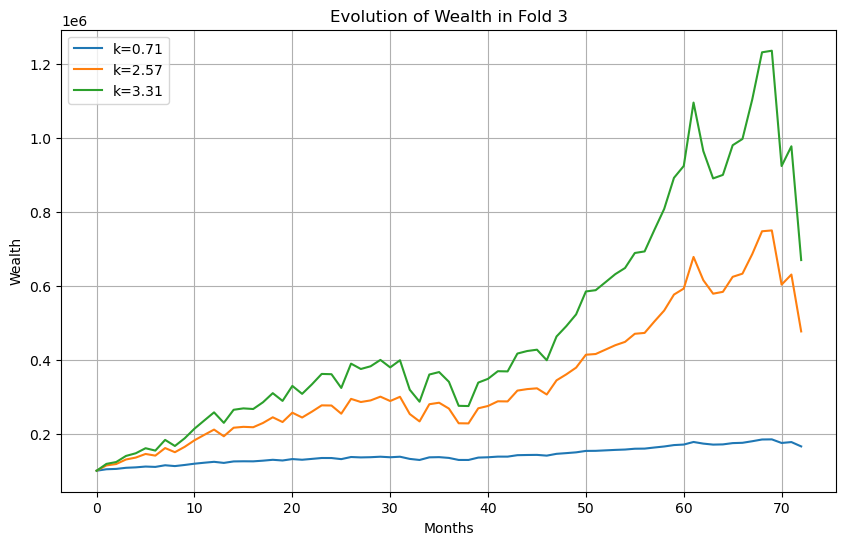

In [6]:
def compute_wealth(k, mkt, rf, initial_wealth=100000):
    w = [initial_wealth]
    for i in range(len(mkt)):
        w.append(w[-1] * (k * (mkt[i] + 1) + (1 - k) * (1 + rf[i])))
    return w

# Compute the evolution of wealth for k=0.71, k=2.55, and k=3.31
k_values = [0.71, 2.57, 3.31]
wealth_evolution = [compute_wealth(k, mkt, rf) for k in k_values]

# Plot the evolution of wealth for the different values of k
plt.figure(figsize=(10, 6))
for i, k in enumerate(k_values):
    plt.plot(wealth_evolution[i], label=f"k={k}")

plt.xlabel('Months')
plt.ylabel('Wealth')
plt.title('Evolution of Wealth in Fold 3')
plt.legend()
plt.grid()
plt.show()


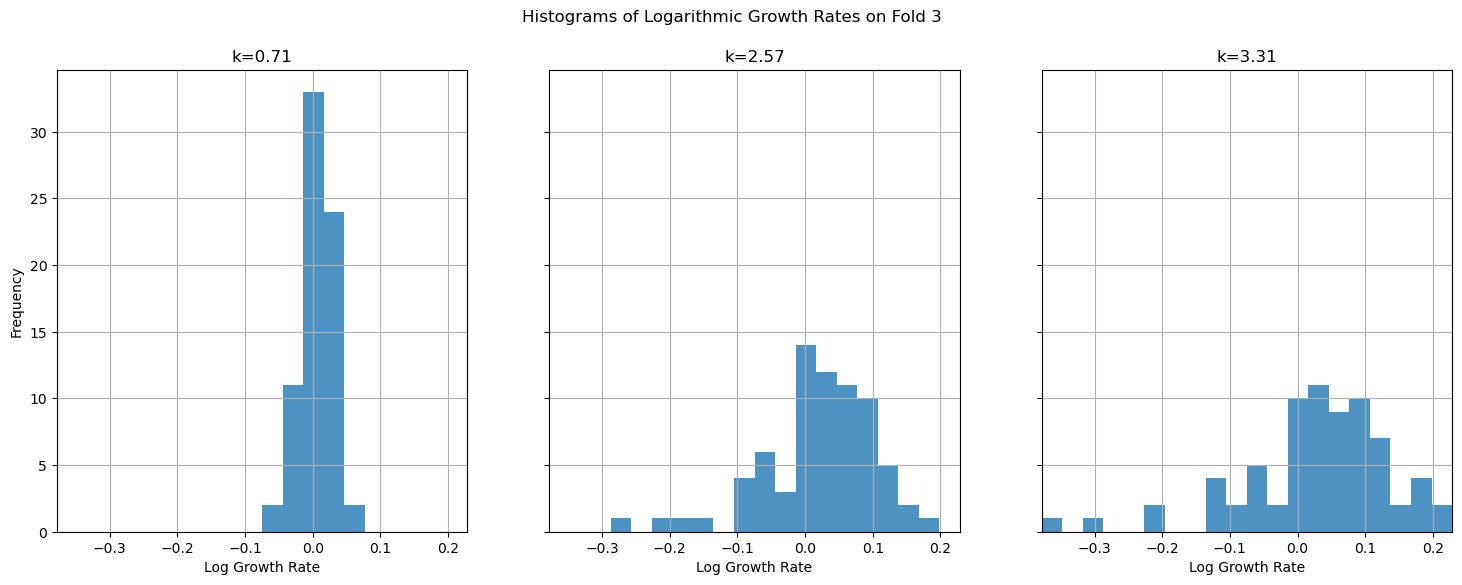

In [7]:
def compute_log_growth_rates(k, mkt, rf):
    wealth = compute_wealth(k, mkt, rf)
    log_growth_rates = np.diff(np.log(wealth))
    return log_growth_rates

# Compute the logarithmic growth rates for k=0.71, k=2.57, and k=3.31
log_growth_rates = [compute_log_growth_rates(k, mkt, rf) for k in k_values]


# Find the minimum and maximum values of the logarithmic growth rates
min_value = min([min(log_growth_rates[i]) for i in range(len(k_values))])
max_value = max([max(log_growth_rates[i]) for i in range(len(k_values))])

# Plot histograms of the logarithmic growth rates for the different values of k
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

for i, k in enumerate(k_values):
    axes[i].hist(log_growth_rates[i], bins=20, alpha=0.8, range=(min_value, max_value))
    axes[i].set_title(f"k={k}")
    axes[i].set_xlabel('Log Growth Rate')
    axes[i].grid()

axes[0].set_ylabel('Frequency')
fig.suptitle('Histograms of Logarithmic Growth Rates on Fold 3')
plt.xlim(min_value, max_value)
plt.show()